<a href="https://colab.research.google.com/github/Saif-M-Dhrubo/hierarchical-attention-HAR/blob/master/MEx_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###CUDA GPU Checking

In [1]:
!nvidia-smi

Wed Apr  8 15:03:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Library Import

In [0]:
import os
import requests
import zipfile
import glob
import platform

import time
import datetime

import pandas as pd
import numpy as np

import missingno as ms

import matplotlib.pyplot as plt
import seaborn as sns

##MEx Dataset

###Routine for Fetching

In [0]:
def get_dataset(url:str, data_directory:str, file_name:str):

    print(datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))
    print('GETTING DATASET ...')

    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    if not os.path.exists(file_name):
        response = requests.get(url, stream=True)
        data_file = open(file_name, 'wb')

        for chunk in response.iter_content(chunk_size=1024):
            data_file.write(chunk)

        data_file.close()
        print('\n---DATASET DOWNLOAD COMPLETE---')

###Data Download

In [0]:
DATA_URL = 'https://data.mendeley.com/datasets/p89fwbzmkd/3/files/227baf25-f0c0-4025-9c9b-9bda2743fbed/MEx.zip?dl=1'
DATA_DIRECTORY = '/'
DATA_FILE = 'MEx.zip'

In [5]:
get_dataset(DATA_URL, DATA_DIRECTORY, DATA_FILE)

2020-04-08 15:03:02
GETTING DATASET ...

---DATASET DOWNLOAD COMPLETE---


In [6]:
!unzip MEx.zip -d MEx_Data/

Archive:  MEx.zip
   creating: MEx_Data/act/
   creating: MEx_Data/act/01/
  inflating: MEx_Data/act/01/01_act_1.csv  
  inflating: MEx_Data/act/01/07_act_1.csv  
  inflating: MEx_Data/act/01/06_act_1.csv  
  inflating: MEx_Data/act/01/05_act_1.csv  
  inflating: MEx_Data/act/01/04_act_1.csv  
  inflating: MEx_Data/act/01/04_act_2.csv  
  inflating: MEx_Data/act/01/03_act_1.csv  
  inflating: MEx_Data/act/01/02_act_1.csv  
   creating: MEx_Data/act/02/
  inflating: MEx_Data/act/02/03_act_1.csv  
  inflating: MEx_Data/act/02/02_act_1.csv  
  inflating: MEx_Data/act/02/01_act_1.csv  
  inflating: MEx_Data/act/02/07_act_1.csv  
  inflating: MEx_Data/act/02/06_act_1.csv  
  inflating: MEx_Data/act/02/05_act_1.csv  
  inflating: MEx_Data/act/02/04_act_1.csv  
  inflating: MEx_Data/act/02/04_act_2.csv  
   creating: MEx_Data/act/03/
  inflating: MEx_Data/act/03/01_act_1.csv  
  inflating: MEx_Data/act/03/07_act_1.csv  
  inflating: MEx_Data/act/03/06_act_1.csv  
  inflating: MEx_Data/act/03/

### Modality-wise Data Directories

In [0]:
DATA_DIR = 'MEx_Data'
THIGH_ACCEL = 'act'
WRIST_ACCEL = 'acw'

### Time Quantization

In [0]:
def quantize_time(timestamp, quantization_level=2):
    m_sec = str(timestamp.microsecond)
    q_msec = m_sec[:quantization_level]

    timestamp = timestamp.replace(microsecond=(int(q_msec) * (10 ** (6 - quantization_level))))

    return timestamp

In [0]:
def get_activity(file_name:str):
    activivity = int(file_name.strip().split('_')[0])

    return activivity

## Data Merge

### Routine for Merging Data from Different Modalities

In [0]:
def get_merged_data():

    complete_df = pd.DataFrame()

    SUBJECT_LIST = ['%02d' % x for x in range(1, 31)]

    for subj in SUBJECT_LIST:
        accel_t_dir = os.path.join(DATA_DIR, THIGH_ACCEL, subj)
        accel_w_dir = os.path.join(DATA_DIR, WRIST_ACCEL, subj)

        accel_t_files = sorted(os.listdir(accel_t_dir))
        accel_w_files = sorted(os.listdir(accel_w_dir))

        for i in range(len(accel_t_files)):
            accel_t = os.path.join(accel_t_dir, accel_t_files[i])
            accel_w = os.path.join(accel_w_dir, accel_w_files[i])

            df_t = pd.read_csv(accel_t, header=None, names=['timestamp', 'act_x', 'act_y', 'act_z'])
            df_w = pd.read_csv(accel_w, header=None, names=['timestamp', 'acw_x', 'acw_y', 'acw_z'])

            df_t['timestamp'] = pd.to_datetime(df_t['timestamp'])
            df_w['timestamp'] = pd.to_datetime(df_w['timestamp'])

            df_t['timestamp'] = df_t['timestamp'].apply(quantize_time)
            df_w['timestamp'] = df_w['timestamp'].apply(quantize_time)

            df_t = df_t.groupby(['timestamp'], as_index=False)['act_x', 'act_y', 'act_z'].mean()
            df_w = df_w.groupby(['timestamp'], as_index=False)['acw_x', 'acw_y', 'acw_z'].mean()

            merged = pd.merge(df_t, df_w, how='outer', on=['timestamp', 'timestamp'], sort=True)
            merged['subject_id'] = int(subj)
            merged['activity'] = get_activity(accel_t_files[i])
            
            complete_df = pd.concat([complete_df, merged], ignore_index=True)

    complete_df = complete_df.sort_values(by='timestamp', ignore_index=True)

    return complete_df

In [15]:
mex_data = get_merged_data()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


### Merged Data Overview

In [37]:
mex_data.sample(15)

,timestamp,act_x,act_y,act_z,acw_x,acw_y,acw_z,subject_id,activity
231258,2018-10-11 11:52:45.940,-0.250000,-0.937500,0.218750,0.546875,0.656250,0.406250,8,5
662353,2019-02-20 12:10:35.750,0.468750,0.765625,0.218750,-0.250000,-0.062500,-1.015625,19,2
214872,2018-10-11 11:45:53.310,-0.250000,0.906250,-0.203125,0.453125,-0.046875,0.781250,8,2
584542,2019-02-14 10:11:25.360,-0.320312,0.890625,-0.148438,0.859375,-0.031250,-0.500000,17,2
443616,2018-11-08 11:51:09.970,0.937500,-0.171875,-0.062500,-0.031250,0.984375,-0.250000,1,6
378617,2018-10-11 15:49:14.830,0.703125,0.406250,0.421875,-0.453125,-0.078125,-0.937500,12,2
471,2018-06-06 09:13:52.540,-0.343750,0.171875,-0.859375,-0.734375,-0.062500,0.625000,3,1
193950,2018-06-13 16:25:02.300,NaN,NaN,NaN,-0.750000,-0.125000,-0.781250,7,5
736904,2019-02-20 13:04:52.740,-0.062500,-0.781250,0.062500,-0.156250,-0.890625,-0.406250,20,7
783399,2019-03-05 13:12:38.790,0.562500,-0.546875,-0.546875,-0.921875,0.031250,0.296875,21,1


In [17]:
mex_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1229840 entries, 0 to 1229839
Data columns (total 9 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   timestamp   1229840 non-null  datetime64[ns]
 1   act_x       1227493 non-null  float64       
 2   act_y       1227493 non-null  float64       
 3   act_z       1227493 non-null  float64       
 4   acw_x       1189207 non-null  float64       
 5   acw_y       1189207 non-null  float64       
 6   acw_z       1189207 non-null  float64       
 7   subject_id  1229840 non-null  int64         
 8   activity    1229840 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 84.4 MB


### Missing Value Analysis

In [18]:
mex_data.isna().sum()

timestamp         0
act_x          2347
act_y          2347
act_z          2347
acw_x         40633
acw_y         40633
acw_z         40633
subject_id        0
activity          0
dtype: int64

In [0]:
null_data = mex_data[mex_data.isna().any(axis=1)]

In [26]:
null_data

,timestamp,act_x,act_y,act_z,acw_x,acw_y,acw_z,subject_id,activity
22,2018-06-06 09:13:47.570,-0.703125,0.656250,-0.125000,NaN,NaN,NaN,3,1
47,2018-06-06 09:13:47.820,-0.656250,0.718750,0.000000,NaN,NaN,NaN,3,1
87,2018-06-06 09:13:48.320,-0.523438,0.789062,0.195312,NaN,NaN,NaN,3,1
112,2018-06-06 09:13:48.570,-0.265625,0.812500,0.484375,NaN,NaN,NaN,3,1
137,2018-06-06 09:13:48.820,-0.171875,0.781250,0.515625,NaN,NaN,NaN,3,1
...,...,...,...,...,...,...,...,...,...
1229835,2019-03-26 17:09:39.750,NaN,NaN,NaN,-0.921875,0.250000,-0.843750,16,7
1229836,2019-03-26 17:09:39.820,-0.171875,-0.921875,-0.328125,NaN,NaN,NaN,16,7
1229837,2019-03-26 17:09:39.860,NaN,NaN,NaN,-1.125000,0.328125,-1.015625,16,7
1229838,2019-03-26 17:09:39.920,-0.156250,-0.890625,-0.328125,NaN,NaN,NaN,16,7


### Missing Value Visualization

In [0]:
def visualize_missing_data(df:pd.DataFrame):
    df_nan = df.copy()
    df_nan.replace(0, np.nan, inplace=True)

    ms.matrix(df_nan)
    plt.show()

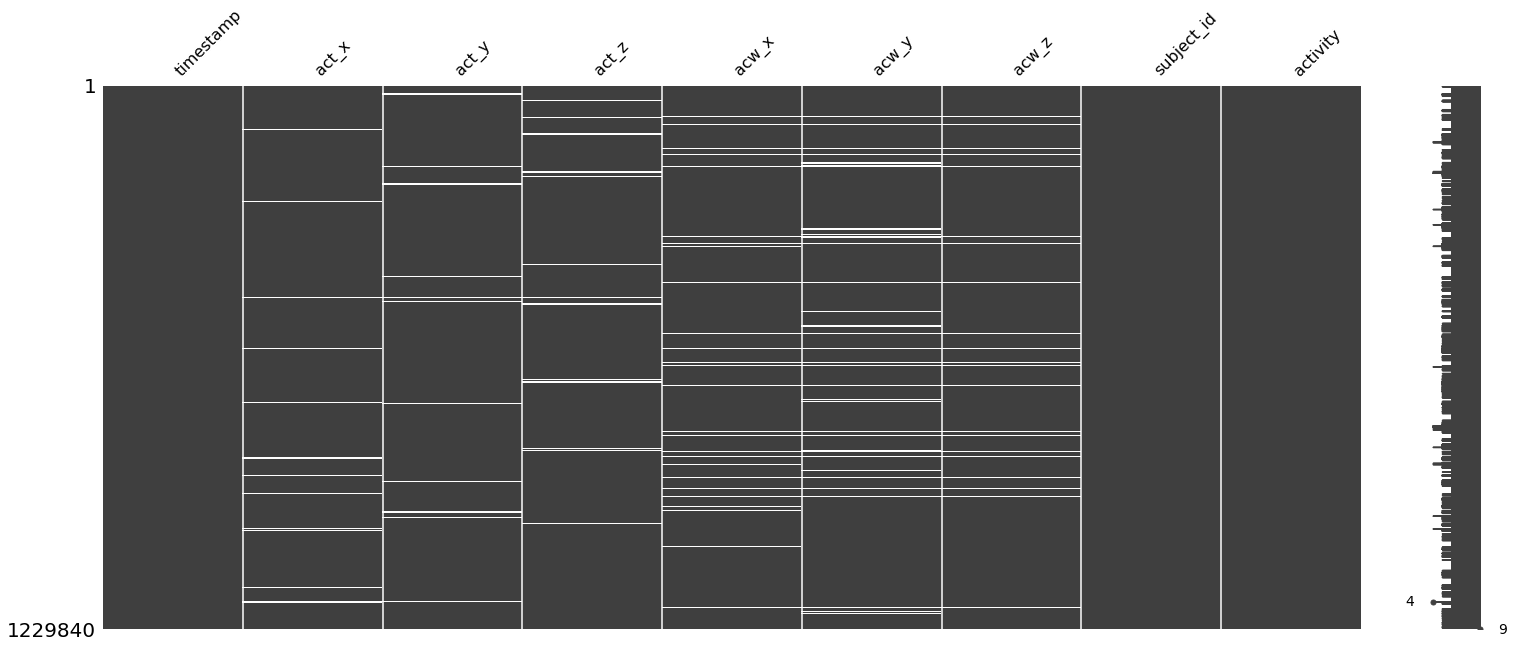

In [47]:
visualize_missing_data(mex_data)

## Data Cleaning

In [0]:
def clean_data(df:pd.DataFrame, method='bfill'):
    clean_df = df.copy().fillna(method=method)
    
    clean_df = clean_df.sort_values(by='timestamp', ignore_index=True)
    clean_df = clean_df.dropna() # Remove null value in last row

    return clean_df

In [0]:
clean_mex_data = clean_data(mex_data)

In [70]:
clean_mex_data

,timestamp,act_x,act_y,act_z,acw_x,acw_y,acw_z,subject_id,activity
0,2018-06-06 09:13:47.350,-0.703125,0.609375,-0.250000,-0.656250,-0.078125,0.687500,3,1
1,2018-06-06 09:13:47.360,-0.703125,0.593750,-0.250000,-0.656250,-0.078125,0.687500,3,1
2,2018-06-06 09:13:47.370,-0.718750,0.593750,-0.250000,-0.656250,-0.078125,0.687500,3,1
3,2018-06-06 09:13:47.380,-0.703125,0.609375,-0.234375,-0.656250,-0.078125,0.687500,3,1
4,2018-06-06 09:13:47.390,-0.718750,0.609375,-0.234375,-0.656250,-0.078125,0.687500,3,1
...,...,...,...,...,...,...,...,...,...
1229834,2019-03-26 17:09:39.720,-0.171875,-0.953125,-0.312500,-0.921875,0.250000,-0.843750,16,7
1229835,2019-03-26 17:09:39.750,-0.171875,-0.921875,-0.328125,-0.921875,0.250000,-0.843750,16,7
1229836,2019-03-26 17:09:39.820,-0.171875,-0.921875,-0.328125,-1.125000,0.328125,-1.015625,16,7
1229837,2019-03-26 17:09:39.860,-0.156250,-0.890625,-0.328125,-1.125000,0.328125,-1.015625,16,7


In [71]:
clean_mex_data.isna().sum()

timestamp     0
act_x         0
act_y         0
act_z         0
acw_x         0
acw_y         0
acw_z         0
subject_id    0
activity      0
dtype: int64

In [0]:
clean_mex_data.to_csv('clean_mex_data.csv', index=False)